<a href="https://colab.research.google.com/github/swilsonmfc/notebooks/blob/master/NeuralNetworksAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders


# Information Bottleneck
![Bottleneck](https://2.bp.blogspot.com/-xdfotR5CIoY/VjJ7UKrFP2I/AAAAAAAAFlM/sHI4T4j0IrY/s1600/autoencoders.png)

# Setup

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [199]:
print(f'Tensorflow Version {tf.__version__}')

Tensorflow Version 2.2.0


# Kaggle

In [200]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [202]:
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Data

In [203]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [204]:
!unzip -q creditcardfraud.zip

replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [205]:
!ls

creditcard.csv	creditcardfraud.zip  sample_data


# EDA

In [206]:
df = pd.read_csv('creditcard.csv')
class_names = ['No Fraud', 'Fraud']

In [208]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


## Fields

In [207]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

## Missing

In [296]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Descriptive Statistics

In [295]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [302]:
no_fraud = df[df.Class == 0].describe().T['mean']
fraud    = df[df.Class == 1].describe().T['mean']
pd.DataFrame({'No Fraud': no_fraud, 'Fraud': fraud})

,No Fraud,Fraud
Time,94838.202258,80746.806911
V1,0.008258,-4.771948
V2,-0.006271,3.623778
V3,0.012171,-7.033281
V4,-0.007860,4.542029
V5,0.005453,-3.151225
V6,0.002419,-1.397737
V7,0.009637,-5.568731
V8,-0.000987,0.570636
V9,0.004467,-2.581123


## Comparison

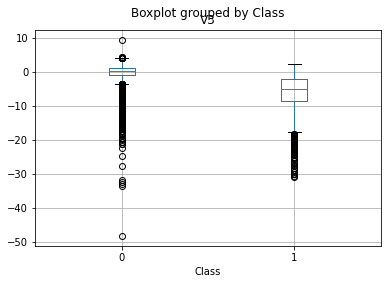

In [303]:
df.boxplot('V3', by='Class')

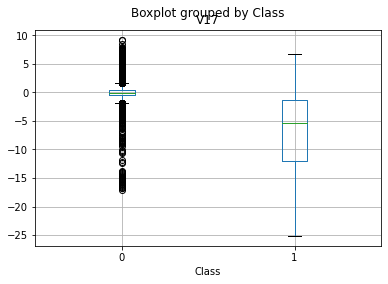

In [304]:
df.boxplot('V17', by='Class')

# Helpers

In [209]:
def reconstruction_error(original, rebuilt, normalize=False):
    loss = np.sum((original - rebuilt) ** 2, axis=1)
    loss = pd.Series(data=loss)
    if normalize:
      loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
    return loss

In [210]:
def plot_performance(history, color_train='blue', color_val='red'):
    fig, ax = plt.subplots(figsize=(12,10))
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    ax = plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'bo', color=color_train, label='Train')
    plt.plot(epochs, val_acc, 'b', color=color_val, label='Validation')
    plt.title('Training & Validation Accuracy')
    plt.ylabel('Accuracy')
    ax.legend()
    
    ax = plt.subplot(2, 1, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)    
    plt.plot(epochs, loss, 'bo', color=color_train, label='Train')
    plt.plot(epochs, val_loss, 'b', color=color_val, label='Validation')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [211]:
def compare_history(histories, metric='val_accuracy', ylabel='Accuracy', title='Validation Accuracy'):
    colors = (c for c in ['blue', 'orange', 'green', 'black', 'red', 'purple'])
    fig, ax = plt.subplots(figsize=(12,10))
    
    ax = plt.subplot(2, 1, 1)
    for key, history in histories.items():
        val_acc = history.history[metric]
        epochs = range(1, len(val_acc) + 1)
        plt.plot(epochs, val_acc, 'b', label=key, color=next(colors))   
        plt.title(title)
        plt.ylabel(ylabel)
    ax.legend()
    
    plt.show();

In [212]:
def print_classification_report(test, pred, target_names=class_names):
  report = classification_report(test, pred, target_names=target_names)
  print(report)  

def plot_confusion(test, pred, class_names=class_names):
    cm = confusion_matrix(test, pred)
    df = pd.DataFrame(cm, class_names, class_names)
    plt.figure(figsize=(10, 10))
    sns.heatmap(df, annot=True, fmt='d', cmap='BuGn')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(test, pred_proba):
  fpr, tpr, _ = roc_curve(test,  pred_proba)
  auc = roc_auc_score(test, pred_proba)
  plt.figure(figsize=(10, 10))
  plt.plot(fpr, tpr, label=f'AUC = {auc}')
  plt.plot([0,1], [0,1], linestyle='--')
  plt.title('ROC Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc=4)
  plt.show()

def plot_precision_recall_curve(test, pred_proba):
  precision, recall, _ = precision_recall_curve(test, pred_proba)
  aps = average_precision_score(y_test, pred_proba)
  plt.figure(figsize=(10, 10))
  plt.plot(recall, precision, label=f'Avg Precision = {aps}')
  plt.plot([0,1], [0.5,0.5], linestyle='--')
  plt.fill_between(recall, 0, precision)
  plt.title('Precision Recall Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(loc=4)
  plt.show()

# Parameters

In [213]:
epochs     = 20
batch_size = 32

# Results
* Reconstruction Error - The distance from actual and rebuilt

In [232]:
results_df = pd.DataFrame(columns=['MAE', 'RMSE', 'LOSS', 'ACC', 'NO_FRAUD', 'FRAUD'])

# Pre-Processing

In [233]:
y = df['Class'].copy()
X = df.copy()
X = X.drop(columns=['Class', 'Time'])

In [234]:
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X['Amount'].values.reshape(-1, 1))
#X = scaler.fit_transform(X)

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1000, stratify=y)

In [236]:
print('Train', X_train.shape, y_train.shape, y_train.sum())
print('Test ', X_test.shape, y_test.shape, y_test.sum())

Train (213605, 29) (213605,) 369
Test  (71202, 29) (71202,) 123


# Complete

## Model

In [237]:
input_size = X.shape[1]
print(input_size)

29


In [238]:
# Input
input_layer = Input(shape=(input_size,))

# Encoder
encoded = Dense(input_size,  activation='relu')(input_layer)

# Output
output_layer = Dense(input_size, activation='linear')(encoded)

# AutoEncoder
model = Model(input_layer, output_layer)

In [239]:
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_31 (Dense)             (None, 29)                870       
_________________________________________________________________
dense_32 (Dense)             (None, 29)                870       
Total params: 1,740
Trainable params: 1,740
Non-trainable params: 0
_________________________________________________________________


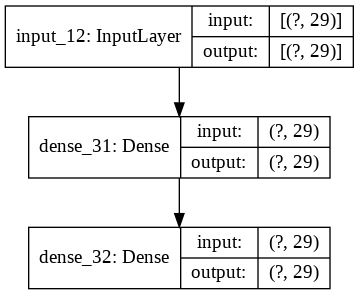

In [240]:
plot_model(model, show_shapes=True)

## Train

In [241]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [242]:
early_stop = EarlyStopping(patience=3, verbose=1)
history_complete = model.fit(X_train, X_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=True,
                             validation_data=(X_test, X_test),
                             callbacks=[early_stop],
                             verbose=1)

Epoch 1/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.1159 - accuracy: 0.8639 - val_loss: 0.0029 - val_accuracy: 0.9810
Epoch 2/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.0033 - accuracy: 0.9769 - val_loss: 0.0021 - val_accuracy: 0.9847
Epoch 3/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.0034 - accuracy: 0.9772 - val_loss: 0.0022 - val_accuracy: 0.9837
Epoch 4/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.0030 - accuracy: 0.9782 - val_loss: 0.0030 - val_accuracy: 0.9815
Epoch 5/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.0028 - accuracy: 0.9789 - val_loss: 0.0011 - val_accuracy: 0.9880
Epoch 6/20
6676/6676 [==============================] - 12s 2ms/step - loss: 0.0014 - accuracy: 0.9853 - val_loss: 1.2425e-04 - val_accuracy: 0.9977
Epoch 7/20
6676/6676 [==============================] - 11s 2ms/step - loss: 8.6403e-04 - accuracy: 0.9892 - val_loss: 9.8322e

## Plots

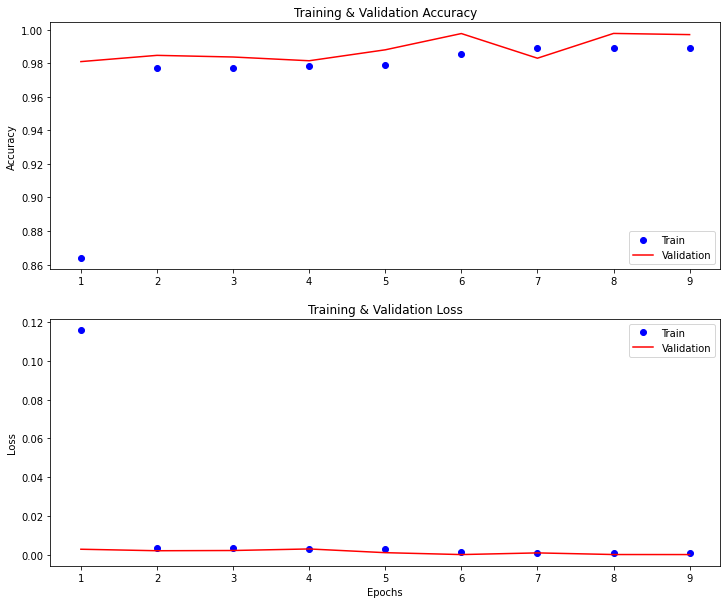

In [243]:
plot_performance(history_complete)

## Test

In [244]:
evaluated = model.evaluate(X_test, X_test) 
pred      = model.predict(X_test)

mae  = mean_absolute_error(X_test, pred)
rmse = math.sqrt(mean_squared_error(X_test, pred))
loss = evaluated[0]
acc  = evaluated[1]

print(f'MAE: {mae:.2f} RMSE: {rmse:.2f}')
print(f'Test Loss     {loss}')
print(f'Test Accuracy {acc}')

2226/2226 [==============================] - 2s 1ms/step - loss: 1.2849e-04 - accuracy: 0.9970
MAE: 0.00 RMSE: 0.01
Test Loss     0.00012849021004512906
Test Accuracy 0.9970365762710571


## Reconstruction

In [245]:
scores = reconstruction_error(X_test, pred)
error_df = pd.DataFrame()
error_df['error']  = scores
error_df['actual'] = y_test 
mean_no_fraud = error_df[error_df.actual == 0]['error'].mean()
mean_fraud    = error_df[error_df.actual == 1]['error'].mean()
error_df.groupby('actual').describe()

error                      ...                                
          count      mean       std  ...       50%       75%         max
actual                               ...                                
0       71079.0  0.003350  0.438375  ...  0.000189  0.000322  116.090133
1         123.0  0.220961  1.496271  ...  0.009794  0.073981   16.445619

[2 rows x 8 columns]

In [246]:
results_df.loc['Complete'] = [mae, rmse, loss, acc, mean_no_fraud, mean_fraud]

# Undercomplete

## Model

In [247]:
input_size = X.shape[1]
print(input_size)

29


In [248]:
# Input
input_layer = Input(shape=(input_size,))

# Encoder
encoded = Dense(input_size // 2,  activation='relu')(input_layer)

# Output
output_layer = Dense(input_size, activation='linear')(encoded)

# AutoEncoder
model = Model(input_layer, output_layer)

In [249]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_33 (Dense)             (None, 14)                420       
_________________________________________________________________
dense_34 (Dense)             (None, 29)                435       
Total params: 855
Trainable params: 855
Non-trainable params: 0
_________________________________________________________________


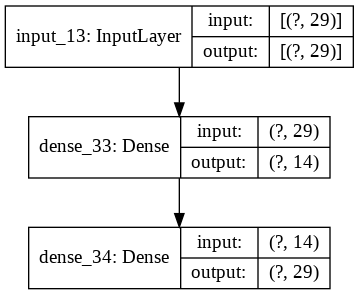

In [250]:
plot_model(model, show_shapes=True)

## Train

In [251]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [252]:
early_stop = EarlyStopping(patience=3, verbose=1)
history_undercomplete = model.fit(X_train, X_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=True,
                             validation_data=(X_test, X_test),
                             callbacks=[early_stop],
                             verbose=1)

Epoch 1/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.3727 - accuracy: 0.6737 - val_loss: 0.2498 - val_accuracy: 0.7970
Epoch 2/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.2483 - accuracy: 0.8100 - val_loss: 0.2458 - val_accuracy: 0.8270
Epoch 3/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.2465 - accuracy: 0.8277 - val_loss: 0.2468 - val_accuracy: 0.8331
Epoch 4/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.2459 - accuracy: 0.8332 - val_loss: 0.2466 - val_accuracy: 0.8378
Epoch 5/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.2457 - accuracy: 0.8345 - val_loss: 0.2441 - val_accuracy: 0.8414
Epoch 6/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.2455 - accuracy: 0.8354 - val_loss: 0.2454 - val_accuracy: 0.8367
Epoch 7/20
6676/6676 [==============================] - 11s 2ms/step - loss: 0.2455 - accuracy: 0.8360 - val_loss: 0.2438 - val_ac

## Plots

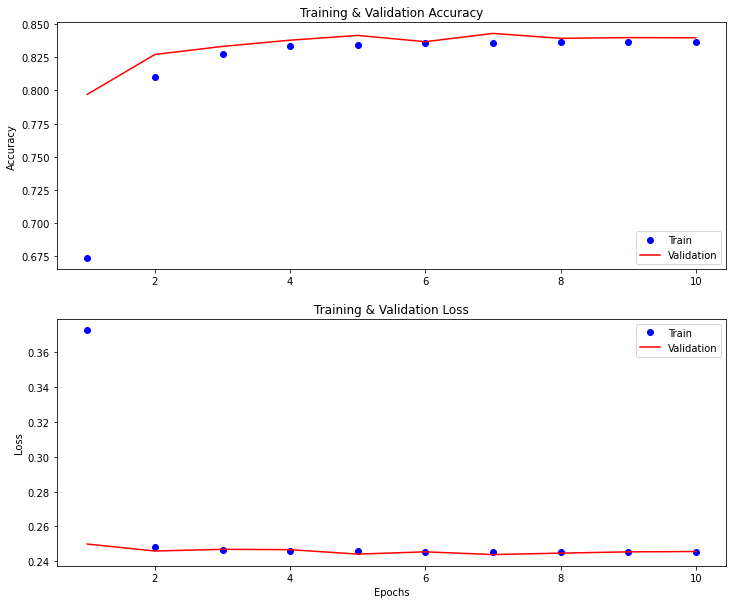

In [253]:
plot_performance(history_undercomplete)

## Test

In [254]:
evaluated = model.evaluate(X_test, X_test) 
pred      = model.predict(X_test)

mae  = mean_absolute_error(X_test, pred)
rmse = math.sqrt(mean_squared_error(X_test, pred))
loss = evaluated[0]
acc  = evaluated[1]

print(f'MAE: {mae:.2f} RMSE: {rmse:.2f}')
print(f'Test Loss     {loss}')
print(f'Test Accuracy {acc}')

2226/2226 [==============================] - 2s 1ms/step - loss: 0.2456 - accuracy: 0.8396
MAE: 0.24 RMSE: 0.50
Test Loss     0.24555522203445435
Test Accuracy 0.8396252989768982


## Reconstruction

In [255]:
scores = reconstruction_error(X_test, pred)
error_df = pd.DataFrame()
error_df['error']  = scores
error_df['actual'] = y_test 
mean_no_fraud = error_df[error_df.actual == 0]['error'].mean()
mean_fraud    = error_df[error_df.actual == 1]['error'].mean()
error_df.groupby('actual').describe()

error                          ...                                    
          count        mean         std  ...        50%         75%          max
actual                                   ...                                    
0       71079.0    6.847952   41.132618  ...   4.182816    7.040090  9716.412645
1         123.0  164.965582  222.358303  ...  64.914811  185.638119   947.428630

[2 rows x 8 columns]

In [256]:
results_df.loc['Under Complete'] = [mae, rmse, loss, acc, mean_no_fraud, mean_fraud]

# Overcomplete

## Model

In [257]:
input_size = X.shape[1]
print(input_size)

29


In [258]:
# Input
input_layer = Input(shape=(input_size,))

# Encoder
encoded = Dense(input_size * 2,  activation='relu', activity_regularizer=l1(1e5))(input_layer)

# Output
output_layer = Dense(input_size, activation='linear')(encoded)

# AutoEncoder
model = Model(input_layer, output_layer)

In [259]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_35 (Dense)             (None, 58)                1740      
_________________________________________________________________
dense_36 (Dense)             (None, 29)                1711      
Total params: 3,451
Trainable params: 3,451
Non-trainable params: 0
_________________________________________________________________


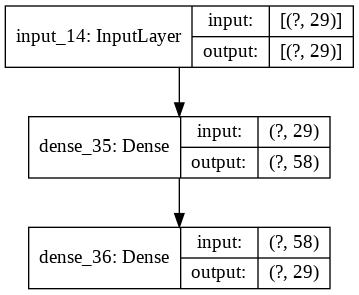

In [260]:
plot_model(model, show_shapes=True)

## Train

In [261]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [262]:
early_stop = EarlyStopping(patience=3, verbose=1)
history_overcomplete = model.fit(X_train, X_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=True,
                             validation_data=(X_test, X_test),
                             callbacks=[early_stop],
                             verbose=1)

Epoch 1/20
6676/6676 [==============================] - 11s 2ms/step - loss: 30133.2969 - accuracy: 0.0697 - val_loss: 3.1363 - val_accuracy: 0.0123
Epoch 2/20
6676/6676 [==============================] - 11s 2ms/step - loss: 6.7675 - accuracy: 0.0659 - val_loss: 1.9157 - val_accuracy: 0.1299
Epoch 3/20
6676/6676 [==============================] - 11s 2ms/step - loss: 1.9289 - accuracy: 0.0813 - val_loss: 1.2067 - val_accuracy: 0.0670
Epoch 4/20
6676/6676 [==============================] - 11s 2ms/step - loss: 1.1294 - accuracy: 0.0728 - val_loss: 1.2067 - val_accuracy: 0.0123
Epoch 5/20
6676/6676 [==============================] - 11s 2ms/step - loss: 1.0895 - accuracy: 0.0506 - val_loss: 1.2066 - val_accuracy: 0.0027
Epoch 6/20
6676/6676 [==============================] - 11s 2ms/step - loss: 1.0895 - accuracy: 0.0589 - val_loss: 1.2066 - val_accuracy: 0.0421
Epoch 7/20
6676/6676 [==============================] - 11s 2ms/step - loss: 1.0895 - accuracy: 0.0635 - val_loss: 1.2067 - va

## Plots

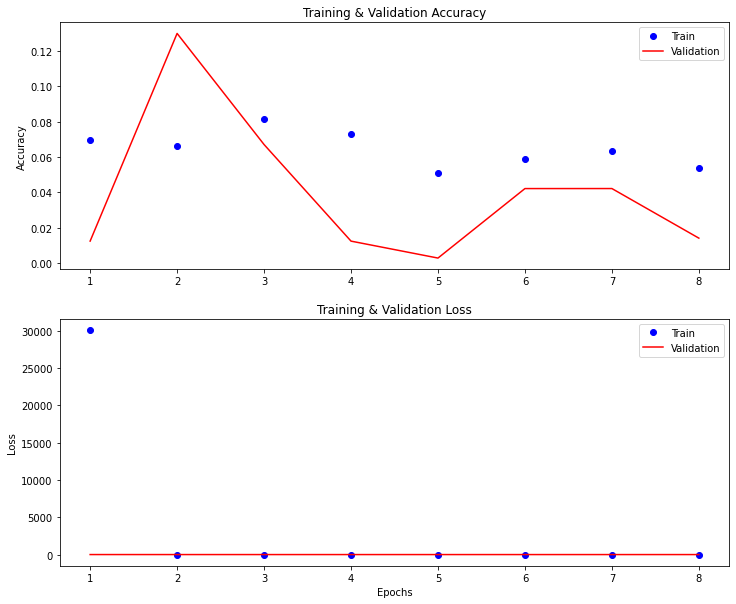

In [263]:
plot_performance(history_overcomplete)

## Test

In [264]:
evaluated = model.evaluate(X_test, X_test) 
pred      = model.predict(X_test)

mae  = mean_absolute_error(X_test, pred)
rmse = math.sqrt(mean_squared_error(X_test, pred))
loss = evaluated[0]
acc  = evaluated[1]

print(f'MAE: {mae:.2f} RMSE: {rmse:.2f}')
print(f'Test Loss     {loss}')
print(f'Test Accuracy {acc}')

2226/2226 [==============================] - 2s 1ms/step - loss: 1.2067 - accuracy: 0.0140
MAE: 0.65 RMSE: 1.05
Test Loss     1.2066748142242432
Test Accuracy 0.014002415351569653


## Reconstruction

In [265]:
scores = reconstruction_error(X_test, pred)
error_df = pd.DataFrame()
error_df['error']  = scores
error_df['actual'] = y_test 
mean_no_fraud = error_df[error_df.actual == 0]['error'].mean()
mean_fraud    = error_df[error_df.actual == 1]['error'].mean()
error_df.groupby('actual').describe()

error                           ...                                      
          count        mean          std  ...         50%         75%           max
actual                                    ...                                      
0       71079.0   30.812237   221.187223  ...   18.220417   28.090412  54541.626539
1         123.0  806.349795  1133.032389  ...  280.371962  759.991837   4633.898860

[2 rows x 8 columns]

In [266]:
results_df.loc['Over Complete'] = [mae, rmse, loss, acc, mean_no_fraud, mean_fraud]

# Compare

In [267]:
results_df

,MAE,RMSE,LOSS,ACC,NO_FRAUD,FRAUD
Complete,0.002979,0.011335,0.000128,0.997037,0.003350,0.220961
Under Complete,0.237758,0.495535,0.245555,0.839625,6.847952,164.965582
Over Complete,0.648561,1.052943,1.206675,0.014002,30.812237,806.349795


# Deep AutoEncoder

## Model
* Multi-Layer UnderComplete AE

In [268]:
# Input
input_layer = Input(shape=(X.shape[1],))

# Encoder
encoded = Dense(X.shape[1], activation='relu')(input_layer)
encoded = Dense(14, activation='relu')(encoded)
encoded = Dense(7,  activation='relu')(encoded)

# Decoder
decoded = Dense(14, activation='relu')(encoded)
output_layer = Dense(X.shape[1], activation='linear')(decoded)

# Output
#output_layer = Dense(2, activation='softmax')(decoded)

# AutoEncoder
model = Model(input_layer, output_layer)

In [269]:
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_37 (Dense)             (None, 29)                870       
_________________________________________________________________
dense_38 (Dense)             (None, 14)                420       
_________________________________________________________________
dense_39 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_40 (Dense)             (None, 14)                112       
_________________________________________________________________
dense_41 (Dense)             (None, 29)                435       
Total params: 1,942
Trainable params: 1,942
Non-trainable params: 0
________________________________________________________

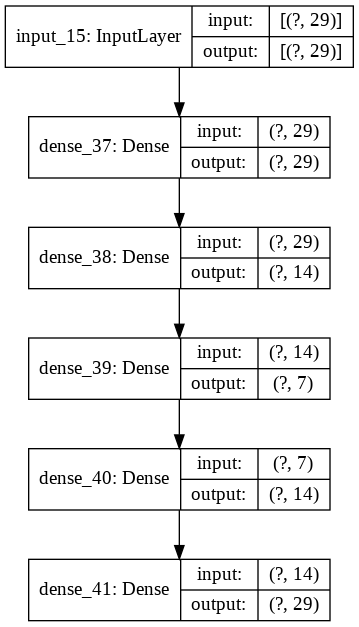

In [270]:
plot_model(model, show_shapes=True)

## Train
* In contrast to complete, over & under, we'll train only on normal transactions

In [271]:
X_train_ae = X_train[y_train == 0]
y_train_ae = y_train[y_train == 0]

print(X_train.shape, y_train.shape)
print(X_train_ae.shape, y_train_ae.shape)

(213605, 29) (213605,)
(213236, 29) (213236,)


In [272]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'accuracy'])

In [273]:
early_stop = EarlyStopping(patience=3, verbose=1)
history_deep = model.fit(X_train_ae, X_train_ae,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=True,
                             validation_data=(X_train_ae, X_train_ae),
                             callbacks=[early_stop],
                             verbose=1)

Epoch 1/20
6664/6664 [==============================] - 17s 3ms/step - loss: 0.4657 - mae: 0.4439 - accuracy: 0.5784 - val_loss: 0.3541 - val_mae: 0.3786 - val_accuracy: 0.6591
Epoch 2/20
6664/6664 [==============================] - 16s 2ms/step - loss: 0.3470 - mae: 0.3730 - accuracy: 0.6623 - val_loss: 0.3336 - val_mae: 0.3621 - val_accuracy: 0.6672
Epoch 3/20
6664/6664 [==============================] - 17s 3ms/step - loss: 0.3319 - mae: 0.3630 - accuracy: 0.6679 - val_loss: 0.3259 - val_mae: 0.3583 - val_accuracy: 0.6727
Epoch 4/20
6664/6664 [==============================] - 17s 3ms/step - loss: 0.3212 - mae: 0.3562 - accuracy: 0.6733 - val_loss: 0.3196 - val_mae: 0.3571 - val_accuracy: 0.6770
Epoch 5/20
6664/6664 [==============================] - 17s 2ms/step - loss: 0.3103 - mae: 0.3508 - accuracy: 0.6801 - val_loss: 0.3013 - val_mae: 0.3451 - val_accuracy: 0.6854
Epoch 6/20
6664/6664 [==============================] - 17s 3ms/step - loss: 0.3003 - mae: 0.3452 - accuracy: 0.686

## Plots

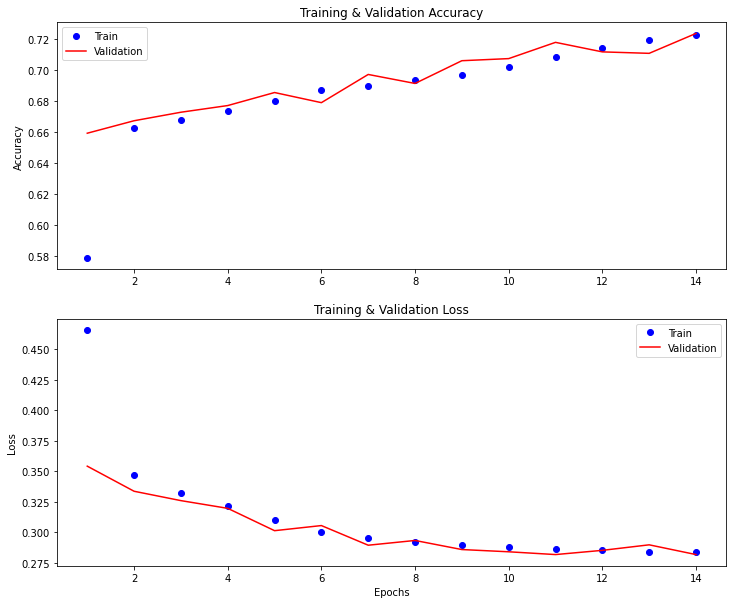

In [274]:
plot_performance(history_deep)

## Test

In [275]:
evaluated = model.evaluate(X_test, X_test) 
pred      = model.predict(X_test)

mae  = mean_absolute_error(X_test, pred)
rmse = math.sqrt(mean_squared_error(X_test, pred))
loss = evaluated[0]
acc  = evaluated[1]

print(f'MAE: {mae:.2f} RMSE: {rmse:.2f}')
print(f'Test Loss     {loss}')
print(f'Test Accuracy {acc}')

2226/2226 [==============================] - 2s 1ms/step - loss: 0.3149 - mae: 0.3281 - accuracy: 0.7273
MAE: 0.33 RMSE: 0.56
Test Loss     0.31490281224250793
Test Accuracy 0.3281382620334625


## Reconstruction

In [276]:
scores = reconstruction_error(X_test, pred)
error_df = pd.DataFrame()
error_df['error']  = scores
error_df['actual'] = y_test 
error_df.groupby('actual').describe()

error                          ...                                      
          count        mean         std  ...         50%         75%           max
actual                                   ...                                      
0       71079.0    8.246492   48.400547  ...    5.499292    9.001248  11519.911243
1         123.0  520.951478  668.335339  ...  222.015717  638.222767   2220.617101

[2 rows x 8 columns]

In [293]:
results_df[['NO_FRAUD', 'FRAUD']]

,NO_FRAUD,FRAUD
Complete,0.003350,0.220961
Under Complete,6.847952,164.965582
Over Complete,30.812237,806.349795


### Separability

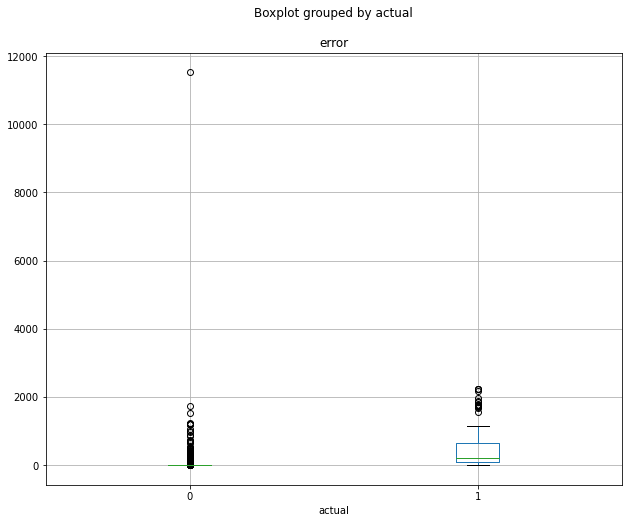

In [298]:
error_df.boxplot('error', by='actual', figsize=(10,8))

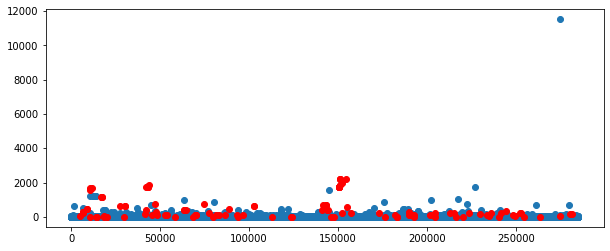

In [277]:
plt.figure(figsize=(10,4))
plt.scatter(error_df[error_df.actual == 0].index, 
            error_df[error_df.actual == 0].error, color='C0')
plt.scatter(error_df[error_df.actual == 1].index, 
            error_df[error_df.actual == 1].error, color='red')

(0.0, 1000.0)

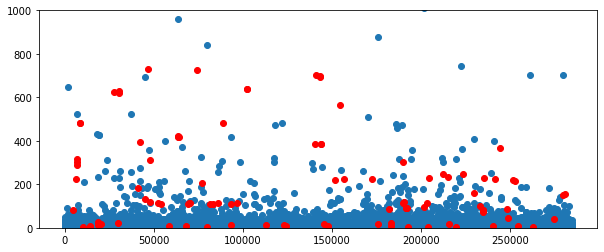

In [278]:
plt.figure(figsize=(10,4))
plt.scatter(error_df[error_df.actual == 0].index, 
            error_df[error_df.actual == 0].error, color='C0')
plt.scatter(error_df[error_df.actual == 1].index, 
            error_df[error_df.actual == 1].error, color='red')
plt.ylim(0, 1000);

## Anomalies

### Threshold

In [279]:
def predict_class_threshold(recon_error, thresh):
  predicted_class = np.where(recon_error > thresh, 1, 0)
  return predicted_class

In [280]:
threshold = 100
pred_test_recon  = model.predict(X_test)
score_test_recon = reconstruction_error(X_test, pred_test_recon)
pred_recon_class = predict_class_threshold(score_test_recon, threshold)

(0.0, 1000.0)

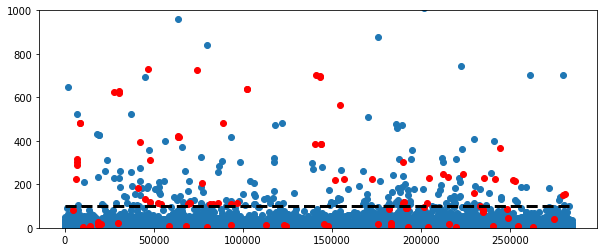

In [281]:
plt.figure(figsize=(10,4))
plt.scatter(error_df[error_df.actual == 0].index, 
            error_df[error_df.actual == 0].error, color='C0')
plt.scatter(error_df[error_df.actual == 1].index, 
            error_df[error_df.actual == 1].error, color='red')
plt.plot([0, max(error_df.index)], [threshold, threshold], linestyle='--', color='black', linewidth=3)
plt.ylim(0, 1000)

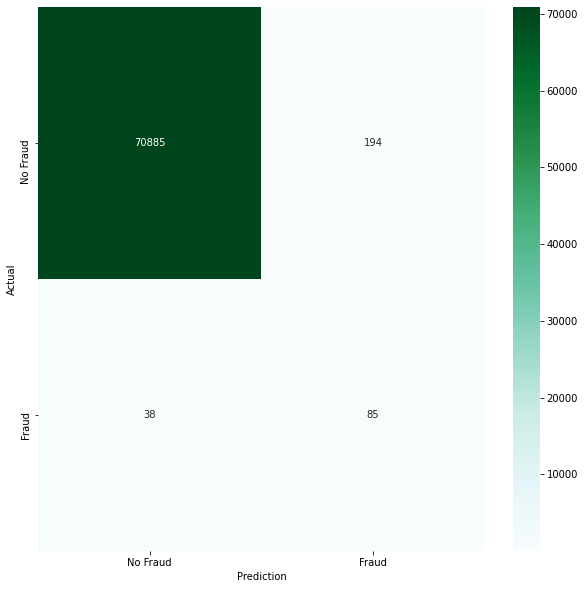

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     71079
       Fraud       0.30      0.69      0.42       123

    accuracy                           1.00     71202
   macro avg       0.65      0.84      0.71     71202
weighted avg       1.00      1.00      1.00     71202



In [282]:
plot_confusion(y_test, pred_recon_class)
print_classification_report(y_test, pred_recon_class)

In [283]:
thresh_df = pd.DataFrame(columns=['Threshold', 'Precision', 'Recall'])
for thresh in range(0, 500, 5):
  predicted_class = predict_class_threshold(score_test_recon, thresh)
  rpt = classification_report(y_test, predicted_class, output_dict=True, target_names=class_names)
  thresh_df.loc[thresh] = [thresh, rpt['Fraud']['precision'], rpt['Fraud']['recall']]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Recall')

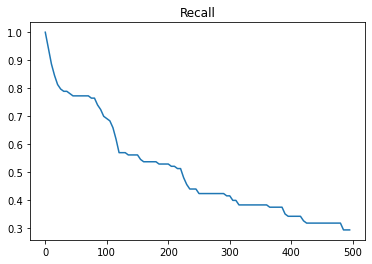

In [284]:
plt.plot(thresh_df['Threshold'], thresh_df['Recall'])
plt.title('Recall')

Text(0.5, 1.0, 'Precision')

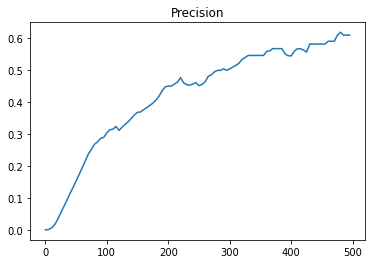

In [285]:
plt.plot(thresh_df['Threshold'], thresh_df['Precision'])
plt.title('Precision')

Text(0.5, 1.0, 'Precision - Recall')

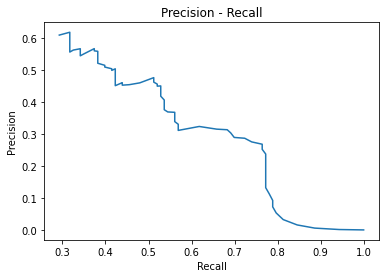

In [286]:
plt.plot(thresh_df['Recall'], thresh_df['Precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall')

### Logistic Regression
* Can we find an optimal threshold?

In [287]:
weights = {0:1, 1:int(len(y_test) / y_test.sum())}
lr = LogisticRegression(class_weight=weights)

pred_train_recon  = model.predict(X_train)
score_train_recon = reconstruction_error(X_train, pred_train_recon)

pred_test_recon  = model.predict(X_test)
score_test_recon = reconstruction_error(X_test, pred_test_recon)

lr.fit(np.array(score_train_recon).reshape(-1, 1), y_train)
pred_recon_proba = lr.predict_proba(np.array(score_test_recon).reshape(-1, 1))
pred_recon_class = lr.predict(np.array(score_test_recon).reshape(-1, 1))

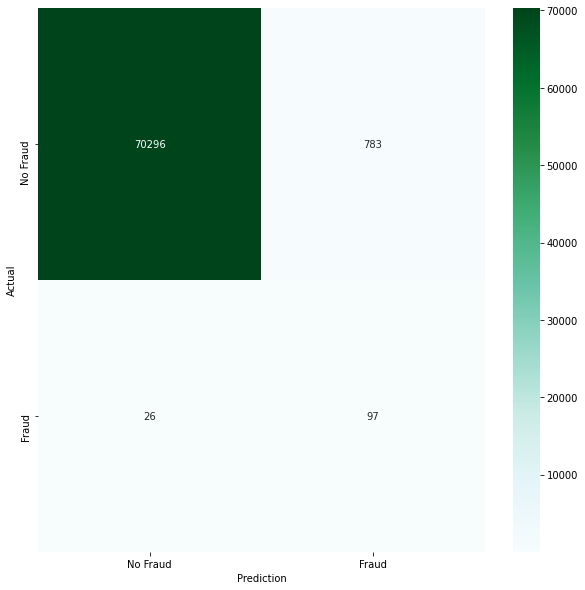

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     71079
       Fraud       0.11      0.79      0.19       123

    accuracy                           0.99     71202
   macro avg       0.55      0.89      0.59     71202
weighted avg       1.00      0.99      0.99     71202



In [288]:
plot_confusion(y_test, pred_recon_class)
print_classification_report(y_test, pred_recon_class)

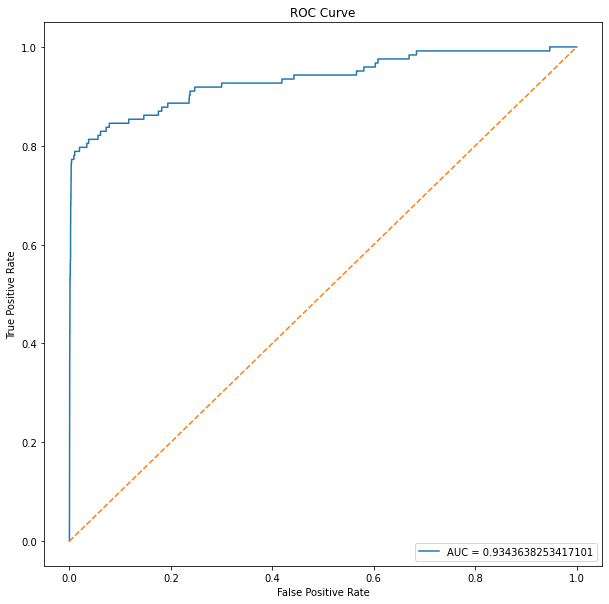

In [289]:
plot_roc_curve(y_test, pred_recon_proba[:,1])

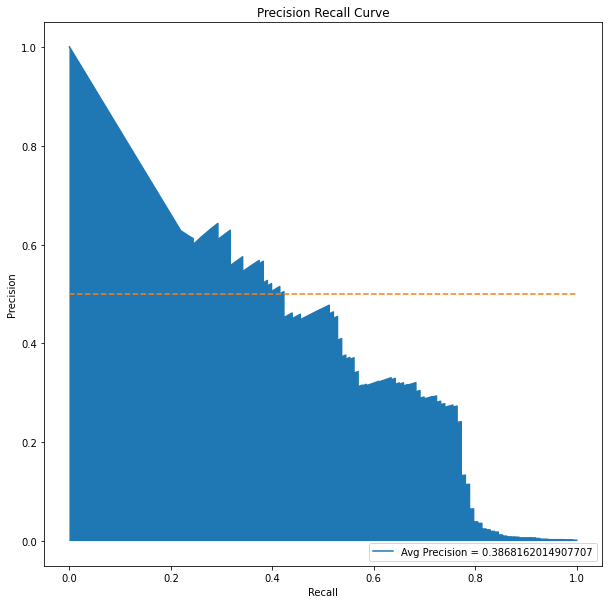

In [290]:
plot_precision_recall_curve(y_test, pred_recon_proba[:,1])

# Recap
* AutoEncoders
  * Information Compression - PCA
  * Normal - Anomaly
* Architectures
  * Complete - Memorize Data
  * Under Complete - Use bottleneck
  * Over Complete - Use regularization & Dropout
* Encoder -> Decoder
  * Seq2Seq (Variable input & output)
  * Transformer (Bert)